In [1]:
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.model_selection import train_test_split

from IPython.display import Image, display

ANNOTATIONS_FILE = "annotations.pkl"
IMAGE_PREFIX = "../data/train/images/"

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [2]:
annotations = pd.read_pickle(ANNOTATIONS_FILE)
annotations = annotations[annotations['chart-type'] == 'vertical_bar']
annotations.head()

,source,chart-type,plot-bb,text,axes,data-series,image
1,generated,vertical_bar,"{'height': 164, 'width': 393, 'x0': 68, 'y0': 37}","[{'id': 0, 'polygon': {'x0': 109, 'x1': 355, '...","{'x-axis': {'ticks': [{'id': 11, 'tick_pt': {'...","[{'x': 'Jordan', 'y': 88.35159235668789}, {'x'...",75c0449f6917.jpg
3,generated,vertical_bar,"{'height': 165, 'width': 396, 'x0': 89, 'y0': 60}","[{'id': 0, 'polygon': {'x0': 71, 'x1': 465, 'x...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'...","[{'x': 'Cuba', 'y': 75695.38632268383}, {'x': ...",58595c30beab.jpg
6,generated,vertical_bar,"{'height': 103, 'width': 408, 'x0': 52, 'y0': 65}","[{'id': 0, 'polygon': {'x0': 49, 'x1': 417, 'x...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'...","[{'x': 'Jamaica', 'y': 36.43411033235605}, {'x...",5022600d52d7.jpg
10,generated,vertical_bar,"{'height': 210, 'width': 427, 'x0': 50, 'y0': 36}","[{'id': 0, 'polygon': {'x0': 28, 'x1': 42, 'x2...","{'x-axis': {'ticks': [{'id': 8, 'tick_pt': {'x...","[{'x': '1', 'y': 62.45402663284719}, {'x': '2'...",32176a89b822.jpg
14,generated,vertical_bar,"{'height': 220, 'width': 427, 'x0': 64, 'y0': 38}","[{'id': 0, 'polygon': {'x0': 74, 'x1': 473, 'x...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'...","[{'x': 'Harney', 'y': 75.91000641635438}, {'x'...",3d895e511690.jpg


In [3]:
from skimage.color import rgb2gray

IMAGE_SIZE = (128, 128)
img_width, img_height = IMAGE_SIZE

def extract_labels(row):
    image = rgb2gray(skimage.io.imread(IMAGE_PREFIX + row['image']))
    tick_labels = [text for text in row['text'] if text['role'] == 'tick_label']
    labels = []
    for tick_label in tick_labels:
        polygon = tick_label['polygon']
        x_min = min(polygon['x0'], polygon['x1'], polygon['x2'], polygon['x3'])
        x_max = max(polygon['x0'], polygon['x1'], polygon['x2'], polygon['x3'])
        y_min = min(polygon['y0'], polygon['y1'], polygon['y2'], polygon['y3'])
        y_max = max(polygon['y0'], polygon['y1'], polygon['y2'], polygon['y3'])
        sub_image = image[y_min:y_max, x_min:x_max]
        output_image = (np.ones(shape=IMAGE_SIZE)*1).astype(float)
        output_image[:len(sub_image),:len(sub_image[0])] = sub_image
        labels.append((output_image, tick_label['text']))
    return labels

# examples = list(itertools.chain.from_iterable(annotations.sample(200, random_state=123).apply(extract_labels, 1).values))

# print(np.array([example[0].shape for example in examples]).max(axis=0))
# len(examples)

In [4]:
annotations_train, annotations_test = train_test_split(annotations.sample(500, random_state=123), test_size=0.2)
annotations_train, annotations_val = train_test_split(annotations_train, test_size=0.2)

train_examples = list(itertools.chain.from_iterable(annotations_train.apply(extract_labels, 1).values))
val_examples = list(itertools.chain.from_iterable(annotations_val.apply(extract_labels, 1).values))
test_examples = list(itertools.chain.from_iterable(annotations_test.apply(extract_labels, 1).values))

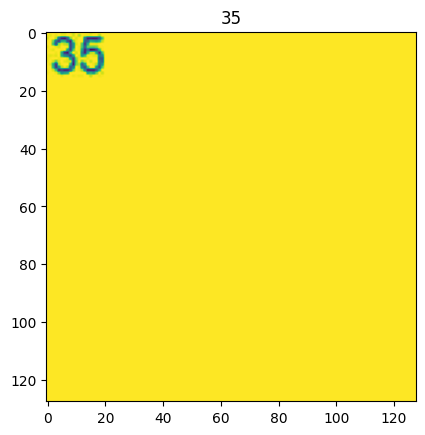

In [5]:
for example in train_examples[:1]:
    plt.imshow(example[0])
    plt.title(example[1])
    plt.show()

In [6]:
train_x, train_y = zip(*train_examples)
val_x, val_y = zip(*val_examples)
test_x, test_y = zip(*test_examples)

print(len(train_x), len(val_x), len(test_x))

6804 1748 2085


In [7]:
characters = set(char for label in train_y for char in label)
characters = sorted(list(characters))

max_length = 32 # max([len(label) for label in train_y])

In [8]:
print("Number of images found: ", len(train_y))
print("Number of labels found: ", len(train_y))
print("Number of unique labels found: ", len(set(train_y)))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)
print("Max. label length: ", max_length, max([len(label) for label in train_y]))

Number of images found:  6804
Number of labels found:  6804
Number of unique labels found:  1446
Number of unique characters:  74
Characters present:  ['\n', ' ', '$', '%', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Max. label length:  32 40


In [9]:
# from: https://keras.io/examples/vision/captcha_ocr/
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = x

    # Define the model
    model = keras.models.Model(
        inputs=input_img, outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Get the model
model = build_model()
model.summary()


2023-03-27 13:48:25.165313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 13:48:30.157466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 13:48:30.159542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split

Model: "ocr_model_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 128, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 64, 64, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 reshape (Reshape)           (None, 32, 2048)          0         
                                                                 
 dense1 (Dense)              (None, 32, 64)           

2023-03-27 13:48:30.909197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 13:48:30.910918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 13:48:30.913899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [10]:
def encode_text(text: str):
    text = tf.strings.substr(text, 0, tf.reduce_min([max_length, tf.strings.length(text)]))
    encoded = char_to_num(tf.strings.unicode_split(text, input_encoding="UTF-8"))
    padding = tf.zeros(max_length - tf.strings.length(text), tf.int64)
    return tf.concat([encoded, padding], 0)

encode_text("bye")

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([50, 73, 53,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

In [11]:
def encode_single_sample(image, label):
    print(label)
    image = tf.reshape(image, (img_width, img_height, 1))
    image = tf.transpose(image, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = encode_text(label)
    # 7. Return a dict as our model is expecting two inputs
    return image, label

batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((list(train_x), list(train_y)))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Tensor("args_1:0", shape=(), dtype=string)


In [12]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

def generator():
    for x, y in zip(train_x, train_y):
        yield x, encode_text(y)

# Train the model
history = model.fit(
    np.stack(train_x),
    tf.stack(list(map(encode_text, train_y))),
    epochs=epochs,
    validation_data=(np.stack(val_x),  tf.stack(list(map(encode_text, val_y)))),
    callbacks=[early_stopping],
)

model.save("models/custom_ocr_1.tf")

Epoch 1/100


2023-03-27 13:49:12.075796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 13:49:12.077929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 13:49:12.079588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

213/213 [==============================] - ETA: 0s - loss: 0.7338 - accuracy: 0.8470

2023-03-27 13:50:17.727092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 13:50:17.728630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 13:50:17.730309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

213/213 [==============================] - 72s 302ms/step - loss: 0.7338 - accuracy: 0.8470 - val_loss: 0.4631 - val_accuracy: 0.8813
Epoch 2/100
213/213 [==============================] - 68s 320ms/step - loss: 0.4969 - accuracy: 0.8696 - val_loss: 0.4228 - val_accuracy: 0.8873
Epoch 3/100
213/213 [==============================] - 67s 315ms/step - loss: 0.4690 - accuracy: 0.8726 - val_loss: 0.4040 - val_accuracy: 0.8914
Epoch 4/100
213/213 [==============================] - 66s 309ms/step - loss: 0.4547 - accuracy: 0.8750 - val_loss: 0.3949 - val_accuracy: 0.8927
Epoch 5/100
213/213 [==============================] - 70s 327ms/step - loss: 0.4425 - accuracy: 0.8770 - val_loss: 0.3819 - val_accuracy: 0.8941
Epoch 6/100
213/213 [==============================] - 68s 321ms/step - loss: 0.4324 - accuracy: 0.8781 - val_loss: 0.3782 - val_accuracy: 0.8936
Epoch 7/100
213/213 [==============================] - 66s 311ms/step - loss: 0.4233 - accuracy: 0.8798 - val_loss: 0.3715 - val_accurac

2023-03-27 15:42:06.792697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 15:42:06.794342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 15:42:06.795484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: models/custom_ocr_1.tf/assets


INFO:tensorflow:Assets written to: models/custom_ocr_1.tf/assets


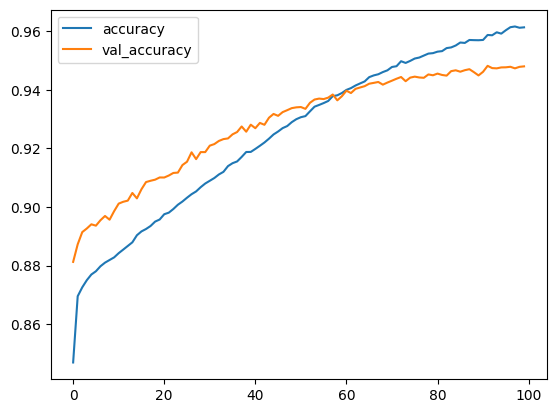

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [14]:
def decode(predictions):
    return ''.join([num_to_char(v).numpy().decode('UTF-8') for v in predictions.argmax(1)])
        

In [15]:
train_y[5]

'10'

In [16]:
decode(model.predict(train_x[5].reshape((1,128,128,1)))[0])

2023-03-27 15:42:30.234428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 15:42:30.235840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 15:42:30.237628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step


'10[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]'

In [17]:
n_predictions = 50
predictions = model.predict(np.stack(train_x[:n_predictions]).reshape(n_predictions, 128, 128, 1))

for prediction, y in list(zip(predictions, train_y)):
    print(y, "-", decode(prediction).split("[UNK]")[0])

2/2 [==============================] - 0s 58ms/step
35 - 35
30 - 30
25 - 25
20 - 20
15 - 15
10 - 10
5 - 5
0 - 0
Washington - Washingnnn
Nebraska - Nebgssaa
Louisiana - Horisgaaa
Indiana - Indiana
Texas - Tkser
Nevada - Nevaaa
Oklahoma - Okaaooaa
Maine - Manie
Montana - Mannhaa
Illinois - Illiaii
3500.0 - 3500.0
3000.0 - 3000.0
2500.0 - 2500.0
2000.0 - 2000.0
1500.0 - 1500.0
1000.0 - 100000
500.0 - 500.0
0.0 - 0.0
100.0 - 100.0
100.0 - 100.0
100.0 - 100.0
100.0 - 100.0
100.0 - 100.0
100.0 - 100.0
100.0 - 100.0
100.0 - 100.0
100.0 - 100.0
91.5 - 96.5
88.7 - 88.
86.4 - 86.
100.0 - 100.0
100.0 - 100.0
90.5 - 90.
Afghanistan - Afghanistan
Africa - Africa
Albania - Almania
Algeria - Algeria
Angola - Algolia
Antigua and... - Antigua and...
Argentina - Argeniiaa
Armenia - Almeniaa
Aruba - Afriaa
